In [153]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Tải các công cụ dự báo cụ thể
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
# Xác định các giá trị p, q
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
# Xây dựng mô hình ARIMA
from pmdarima import auto_arima
from pmdarima.arima import auto_arima

# Loại bỏ các thông báo vô hại
import warnings
warnings.filterwarnings("ignore")

In [154]:
#đọc dữ liệu
df = pd.read_csv('stock_prices.csv')
#xem thông tin dữ liệu
df.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [155]:

df[df['SecuritiesCode'] ==1301]

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1865,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920
3730,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092
5595,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100
7460,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...
2322531,20211129_1301,2021-11-29,1301,2975.0,2984.0,2951.0,2951.0,14300,1.0,NaN,False,0.003793
2324531,20211130_1301,2021-11-30,1301,2953.0,2997.0,2900.0,2900.0,20500,1.0,NaN,False,0.007558
2326531,20211201_1301,2021-12-01,1301,2909.0,2936.0,2909.0,2911.0,10600,1.0,NaN,False,0.016706
2328531,20211202_1301,2021-12-02,1301,2949.0,2973.0,2933.0,2933.0,15200,1.0,NaN,False,-0.003689


In [157]:
close_avg=train.groupby('Date')['Close'].mean()
#train_date=train.Date.unique()

In [158]:
train_date[:5]

array(['04-01-17', '05-01-17', '06-01-17', '10-01-17', '11-01-17'],
      dtype=object)

In [159]:
close_avg

Date
01-02-17    43860.0
01-02-18    68670.0
01-03-17    44000.0
01-03-18    63870.0
01-05-17    45640.0
             ...   
28-02-17    43460.0
28-02-18    65270.0
28-03-17    44880.0
28-03-18    64900.0
28-04-17    44800.0
Name: Close, Length: 446, dtype: float64

In [160]:
df=pd.DataFrame(data=close_avg)
df

,Close
Date,
01-02-17,43860.0
01-02-18,68670.0
01-03-17,44000.0
01-03-18,63870.0
01-05-17,45640.0
...,...
28-02-17,43460.0
28-02-18,65270.0
28-03-17,44880.0


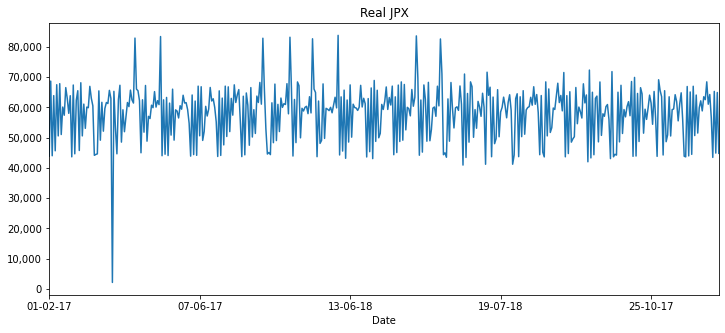

In [161]:
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real JPX'
ylabel=''
xlabel='Date' 

ax = df['Close'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

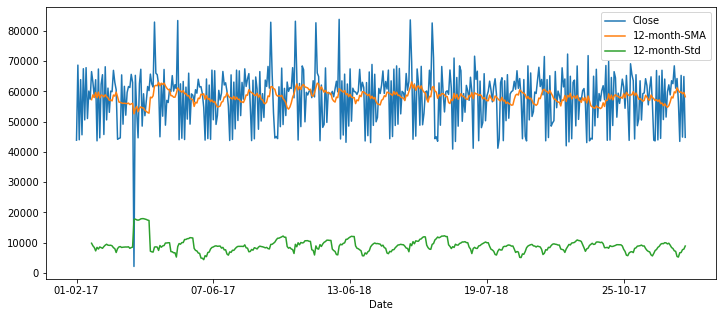

In [162]:
#Vẽ đường giá trị trung bình và đường phương sai của mô hình
df['12-month-SMA'] = df['Close'].rolling(window=12).mean()
df['12-month-Std'] = df['Close'].rolling(window=12).std()
df[['Close','12-month-SMA','12-month-Std']].plot(figsize=(12,5));

In [163]:
#hàm kiểm định ADF
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):

    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','Number of lags used','Number of observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [164]:
#Chạy hàm tên adf_test để kiểm định tính dừng của thuộc tính Close trong chuỗi thời gian và đặt tên là Real Stock
adf_test(df['Close'],'Real Stock')

Augmented Dickey-Fuller Test: Real Stock
ADF test statistic         -3.988877
p-value                     0.001470
Number of lags used        18.000000
Number of observations    427.000000
critical value (1%)        -3.445758
critical value (5%)        -2.868333
critical value (10%)       -2.570388
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [7]:
#Giá trị p-value = 0.001< 0.05 nên chuỗi ETH dừng tại sai phân bậc 0 

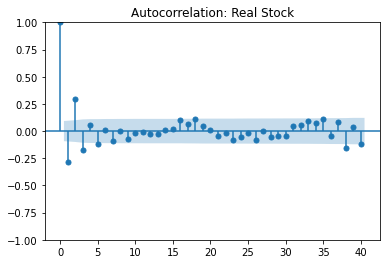

In [165]:
#Vẽ mô hình ACF và mô hình PACF của chuỗi dừng
#ACF của chuỗi thời gian 
title = 'Autocorrelation: Real Stock'
lags = 40
plot_acf(df['Close'],title=title,lags=lags);

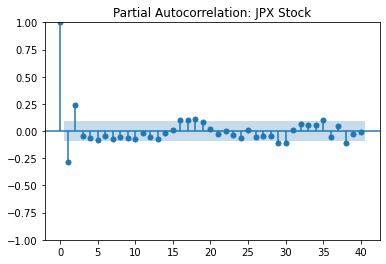

In [166]:
#PACF của chuỗi thời gian
title = 'Partial Autocorrelation: JPX Stock'
lags = 40
plot_pacf(df['Close'],title=title,lags=lags);

In [10]:
#Xây dựng mô hình ARIMA với giá trị p bắt đầu là 0 và giá trị q bắt đầu là 0 và không có tính mùa vụ.

In [167]:
multiple_model = auto_arima(df['Close'], start_p=0, start_q=0,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

multiple_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11063.385, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=9811.639, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=10809.169, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9360.101, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9396.072, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=9336.416, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=9337.127, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9337.930, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9360.037, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=9339.096, Time=0.35 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 1.840 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  446
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -4664.208
Date:                Mon, 13 Jun 2022   AIC                           9336.416
Time:                        00:56:59   BIC                           9352.818
Sample:                             0   HQIC                          9342.883
                                - 446                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.689e+04   3671.372     15.494      0.000    4.97e+04    6.41e+04
ar.L1         -0.2184      0.043     -5.082      0.000      -0.303      -0.134
ar.L2          0.2392      0.042      5.684      0.000       0.157       0.322
sigma2      7.078e+07      0.329   2.15e+08      0.000    7.08e+07    7.08e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               422.42
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.74
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.48e+23. Standard errors may be unstable.
"""

In [12]:
#Ta nhìn vào AIC để lựa chọn mô hình phù hợp. 
#Vì mô hình mất càng ít thông tin thì chất lượng của mô hình đó càng cao nên ta chọn mô hình AIC có giá trị thấp nhất

In [168]:
#Cách khác: dùng hàm auto_arima để xuất mô hình phù hợp
model = auto_arima(df['Close'],seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  446
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -4664.208
Date:                Mon, 13 Jun 2022   AIC                           9336.416
Time:                        00:57:07   BIC                           9352.818
Sample:                             0   HQIC                          9342.883
                                - 446                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   5.689e+04   3671.372     15.494      0.000    4.97e+04    6.41e+04
ar.L1         -0.2184      0.043     -5.082      0.000      -0.303      -0.134
ar.L2          0.2392      0.042      5.684      0.000       0.157       0.322
sigma2      7.078e+07      0.329   2.15e+08      0.000    7.08e+07    7.08e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               422.42
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -0.74
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.48e+23. Standard errors may be unstable.
"""

In [14]:
#Tiến hành train và test mô hình ARIMA(0,1,0) và đánh giá

In [169]:
#Lấy chiều dài của tập dữ liệu
len(df)

446

In [170]:
#Tạo biến interrupt để lấy 90% dữ liệu đầu cho tập huấn luyện và 10% còn lại cho tập kiểm định
interrupt = int(len(df) * 0.9)
interrupt

401

In [171]:
#Tạo tập dữ liệu huấn luyện và kiểm tra
train = df.iloc[:interrupt]
test = df.iloc[interrupt:]

In [172]:
#Xây dựng mô hình từ dữ liệu huấn luyện từ mô hình ARIMA với các thông số p, d, q đã tìm ở trên
model = sm.tsa.SARIMAX(train['Close'],order=(2, 0, 0))
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  401
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -4265.388
Date:                Mon, 13 Jun 2022   AIC                           8536.775
Time:                        00:57:35   BIC                           8548.757
Sample:                             0   HQIC                          8541.520
                                - 401                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2684      0.030      8.834      0.000       0.209       0.328
ar.L2          0.7231      0.029     24.884      0.000       0.666       0.780
sigma2      9.999e+07   9.19e-11   1.09e+18      0.000       1e+08       1e+08
===================================================================================
Ljung-Box (L1) (Q):                  11.67   Jarque-Bera (JB):               404.54
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.94
Prob(H) (two-sided):                  0.27   Kurtosis:                         7.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.86e+33. Standard errors may be unstable.
"""

In [173]:
#Tìm kiếm giá trị dự đoán từ 10% dữ liệu cuối của tập dữ liệu
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(2,0,0) Predictions')

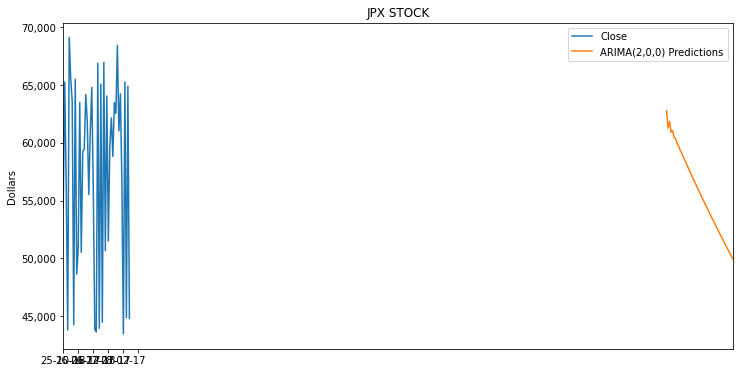

In [174]:
#Vẽ đồ thị thể hiện các giá trị dự đoán từ mô hình ARIMA (2, 0, 0) với dữ liệu ban đầu

title = 'JPX STOCK'
ylabel='Dollars'
xlabel='' 

ax = test['Close'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [175]:
#Đánh giá mô hình
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Close'], predictions)
print(f'ARIMA(2,0,0) MSE Error: {error:11.10}')

ARIMA(2,0,0) MSE Error: 82916115.49


In [145]:
#So sánh chỉ số MAPE (Mean absolute percentage error)
#MAPE là phần trăm sai số tuyệt đối dùng để kiểm tra độ chính xác của mô hình

In [176]:
#RMSE là Căn bậc 2 của trung bình bình phương sai số 
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Close'], predictions)
print(f'ARIMA(0,1,0) RMSE Error: {error:11.10}')

ARIMA(0,1,0) RMSE Error: 9105.828655


In [177]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [178]:
#MAPE là Sai số phần trăm tuyệt đối trung bình, thường biểu thị độ chính xác dưới dạng tỷ lệ
smape_kun(test["Close"], predictions)

MAPE: nan % 
SMAPE: 0.00 %


In [179]:
#Đào tạo lại mô hình trên dữ liệu đầy đủ và dự báo tương lai
model = sm.tsa.statespace.SARIMAX(df['Close'],order=(0,1,0))
results = model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('ARIMA(2,0,0) Forecast')

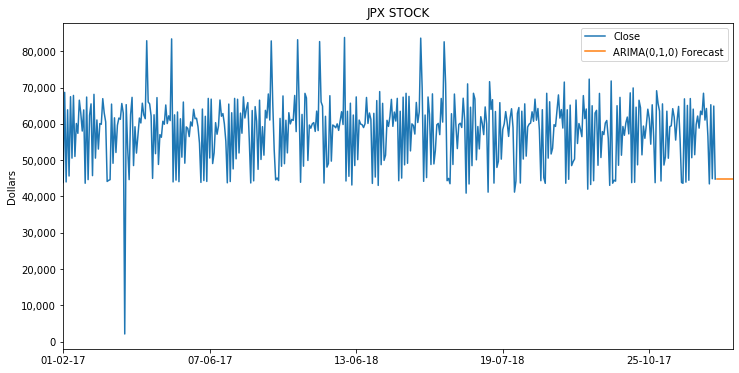

In [180]:

title = 'JPX STOCK'
ylabel='Dollars'
xlabel=''

ax = df['Close'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [181]:
print(results.forecast(1))

446    44800.0
dtype: float64


In [182]:
print(results.forecast(10))

446    44800.0
447    44800.0
448    44800.0
449    44800.0
450    44800.0
451    44800.0
452    44800.0
453    44800.0
454    44800.0
455    44800.0
Name: predicted_mean, dtype: float64
